In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpyro.infer import MCMC, NUTS, Predictive
import jax.random as random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

from datetime import datetime
import datetime as dt

from pycoingecko import CoinGeckoAPI

/Users/tom/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<AxesSubplot:xlabel='stateTime'>

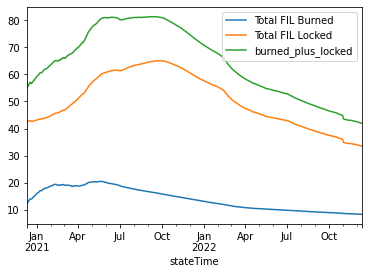

In [2]:
# downloaded from https://dashboard.starboard.ventures/dashboard
df = pd.read_csv('offline_info/FIL_Locked_and_Burnt_as_%_of_Circulating_Supply.csv')
df = df[df['stateTime'] >= '2020-12-11'] # last couple days not available yet
df = df[df['stateTime'] <= '2022-12-11'] # look at the past 2 years
df.reset_index(inplace = True)
df['burned_plus_locked'] = df['Total FIL Burned'] + df['Total FIL Locked']
df.drop('index',axis=1, inplace=True)
df['stateTime'] = pd.to_datetime(df['stateTime'])
df = df.set_index('stateTime').resample('D').interpolate(method='ffill')
df.plot()

In [3]:
# get price data
cg = CoinGeckoAPI()
def get_ts(id_='filecoin'):
    
    change_t = lambda x : datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
    now = int(datetime.utcnow().timestamp())
    start_ago = int((datetime.utcnow() - dt.timedelta(800)).timestamp())
    ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                              vs_currency='usd',
                                              from_timestamp=start_ago,to_timestamp=now
                                             )

    
    ts_df = pd.DataFrame({"coin" : id_,
                          "time_s" : np.array(ts['prices']).T[0],
                      "time_d" : list(map(change_t, np.array(ts['prices']).T[0])),
                      "price" : np.array(ts['prices']).T[1],
                      "market_caps" : np.array(ts['market_caps']).T[1], 
                      "total_volumes" : np.array(ts['total_volumes']).T[1]})
    ts_df['time_d'] = pd.to_datetime(ts_df['time_d'])
    
    return ts_df

In [8]:
# get data, filter, and standardise
price_df_fil, price_df_btc, price_df_eth = get_ts('filecoin'), get_ts('bitcoin'), get_ts('ethereum')

price_df_fil = price_df_fil.pipe(lambda x: x[x['time_d'] <= df.index.max()])
price_df_fil = price_df_fil.pipe(lambda x: x[x['time_d'] >= df.index.min()])

price_df_eth = price_df_eth.pipe(lambda x: x[x['time_d'] <= df.index.max()])
price_df_eth = price_df_eth.pipe(lambda x: x[x['time_d'] >= df.index.min()])

price_df_btc = price_df_btc.pipe(lambda x: x[x['time_d'] <= df.index.max()])
price_df_btc = price_df_btc.pipe(lambda x: x[x['time_d'] >= df.index.min()])

price_df = pd.DataFrame({'date': price_df_fil['time_d'].values, 
                         'FIL' : price_df_fil['price'].values,
                        'BTC' : price_df_btc['price'].values,
                         'ETH' : price_df_eth['price'].values,})
price_df['burned_plus_locked'] = df['burned_plus_locked'].values

price_df[['FIL','BTC','ETH','burned_plus_locked']] = price_df[['FIL',
                                                               'BTC',
                                                               'ETH',
                                                               'burned_plus_locked']].pipe(lambda x: (x - x.mean())/x.std())

<AxesSubplot:>

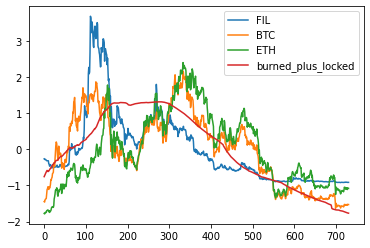

In [9]:
price_df[['FIL','BTC','ETH','burned_plus_locked']].plot()

In [10]:
# Define model to explain variation in FIL
# in terms of BTC, burned_plus_locked and random variation

X_ = price_df.index.values
y_ = price_df.FIL

def model(y=None, 
          X=X_, 
          BTC=price_df['BTC'].values,
          burned_plus_locked=price_df['burned_plus_locked'].values,
          periodicity=14):
    y_sigma = numpyro.sample('y_sigma', dist.HalfNormal(scale=1))
    
    beta_fil = numpyro.sample('beta_fil', dist.Normal(0,1))
    beta_btc = numpyro.sample('beta_btc', dist.Normal(0,1))
    beta_burned_plus_locked = numpyro.sample('beta_burned_plus_locked', dist.Normal(loc=0,scale=1))
    
    nsteps = X.shape[0] // periodicity
    mu = numpyro.sample('rw', dist.GaussianRandomWalk(scale=1, num_steps=nsteps))
    mu = jnp.repeat(mu, periodicity)
    mu = jnp.append(mu, jnp.repeat(mu[-1], X.shape[0] % periodicity))
    mu += beta_btc * BTC + beta_burned_plus_locked * burned_plus_locked
    
    numpyro.sample('obs', dist.Normal(loc=mu, scale=y_sigma), obs=y)

In [11]:
# Run the model with a breakpoint at idx 652 (~1 week for Skyr upgrade)
# As a test to see if i) model fits data ii) breakpoint effect size is reasonable
INOVATIONS = 31
mcmc = MCMC(
            NUTS(model), 
            num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0), y=jnp.array(y_), 
         X=jnp.array(X_), 
         BTC=jnp.array(price_df['BTC'].values),
         burned_plus_locked=jnp.array(price_df['burned_plus_locked'].values), 
         periodicity=INOVATIONS)

sample: 100%|█████████████| 2000/2000 [00:03<00:00, 522.92it/s, 31 steps of size 6.50e-02. acc. prob=0.94]


/Users/tom/opt/anaconda3/lib/python3.9/site-packages/xarray/core/groupby.py:204: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  return index.is_unique and index.is_monotonic
/Users/tom/opt/anaconda3/lib/python3.9/site-packages/xarray/core/groupby.py:204: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  return index.is_unique and index.is_monotonic


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

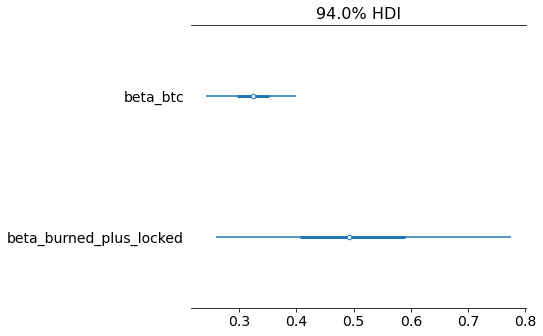

In [12]:
# check the effect sizes and significance:
# null result is zero
az.plot_forest(az.from_numpyro(mcmc),var_names=['beta_btc','beta_burned_plus_locked'])

In [13]:
# results indicate market and burned_over_locked correlation
samples = mcmc.get_samples()
samples['beta_burned_plus_locked'].mean(), samples['beta_burned_plus_locked'].std()

(DeviceArray(0.4982106, dtype=float32), DeviceArray(0.13477767, dtype=float32))

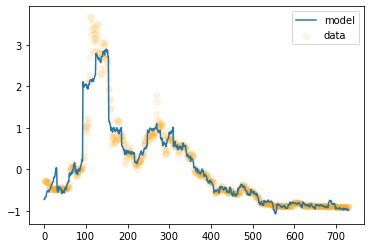

In [14]:
# sanity check the model predictions are reproducing the data
rng_key = random.PRNGKey(0)
predictive = Predictive(model, samples)
predictions = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC'].values),
         burned_plus_locked=jnp.array(price_df['burned_plus_locked'].values),  
                         periodicity=31,)["obs"]

plt.plot(jnp.median(predictions,axis=0), label='model')
plt.scatter(X_, price_df[['FIL']],alpha=0.1,c='orange', label='data')
plt.legend()
plt.show()

**Interpretation**
* (Burned+Locked) / Circulating Supply is a significant factor, as important as wider market correlation (BTC proxy).